In [1]:
from __future__ import print_function
import pandas as pd
import pickle
import numpy as np
from itertools import chain
from collections import OrderedDict
%load_ext autoreload
import random

# Load the dataset! 

In [2]:
# Load the bar review dataset 
review = pd.read_pickle('../output/bar_reviews_cleaned_and_tokenized.pickle')

# Drop 20% of the users from the dataset for testing
user_set = list(set(review.user_id.values[:]))
random.seed(0)
shuffle(user_set) # Randomize 
n_users = float(len(user_set))

user_set_training = user_set[:int(n_users*float(0.8))]
with open('../output/training_users.pickle', 'wb') as f: 
    pickle.dump(user_set_training, f)
    
# Save a test set
test_users = user_set[int(n_users*float(0.8)):]
with open('../output/test_users.pickle', 'wb') as f: 
    pickle.dump(test_users, f)
    
# Make the active review set training only 
review = review[review.user_id.isin(user_set_training)]


# Merging the documents by (i) business, (ii) users

In [ ]:
# This is for review level not business level 
# docs = [" ".join(list(chain.from_iterable(l))) for l in review.cleaned_tokenized.iloc[:]]

n_reviews = -1 # all of them... 
# Flatten the reviews, so each review is just a single list of words.
reviews_merged_bus = OrderedDict()
business_set = set(review.business_id.values[:n_reviews])
for i_bus, bus_id in enumerate(business_set):
    if ((i_bus%2)==0):
        print ('\r Fraction Processed',float(i_bus+1)/len(business_set), end="") 
    # This horrible line first collapses each review of a corresponding business into a list
    # of lists, and then collapses the list of sentences to a long list of words
    reviews_merged_bus[bus_id] = " ".join(list(chain.from_iterable( 
                                    chain.from_iterable( review.cleaned_tokenized[review.business_id==bus_id] ))))    
docs_bus = reviews_merged_bus.values()

with open('../output/docs_bars_bus.pickle', 'wb') as f: 
    pickle.dump(docs_bus, f)


 Fraction Processed 1.0

In [ ]:
# Flatten the reviews, so each review is just a single list of words.
reviews_merged_user = OrderedDict()

user_set = list(set(review.user_id.values[:n_reviews]))
n_users = float(len(user_set))
for i_user, user_id in enumerate(user_set[:]):
    if ((i_user%50)==0):
        print ('\r Fraction Processed',float(i_user+1)/n_users, end="") 
    # This horrible line first collapses each review of a corresponding user reviews into a list
    # of lists, and then collapses the list of sentences to a long list of words
    reviews_merged_user[user_id] = " ".join(list(chain.from_iterable( 
                                    chain.from_iterable( review.cleaned_tokenized[review.user_id==user_id] ))))    
docs_users = reviews_merged_user.values()
print()
print("Merging Done...")

with open('../output/docs_bars_users.pickle', 'wb') as f: 
    pickle.dump(docs_users, f)


 Fraction Processed 0.0681254257079

# LDA Across Bars and Businesses

In [ ]:
%autoreload 2 
import sys
sys.path.append('../vectorsearch/')
import LDA

n_topics=20 
n_features=10000
max_df=.75
min_df=2
max_iter=5

In [ ]:
# Train the bar set over businesses
doc_users = pickle.load(open('../output/docs_bars_users.pickle', 'rb'))

lda_bus = LDA.LDA(n_topics=n_topics, n_features=n_features, max_df=max_df, min_df=min_df, max_iter=max_iter,)
lda_bus.vectorizecounts(docs_bus)
lda_bus.fitLDA()
LDA.SaveLDAModel('../output/LDA_model_bus.pickle', lda_bus)
# Now can 

In [ ]:
# Train the bar set over users

doc_users = pickle.load(open('../output/docs_bars_users.pickle', 'rb'))
lda_user = LDA.LDA(n_topics=n_topics, n_features=n_features, max_df=max_df, min_df=min_df, max_iter=max_iter,)
lda_user.vectorizecounts(docs_users)
lda_user.fitLDA()
LDA.SaveLDAModel('../output/LDA_model_user.pickle', lda_user)

In [ ]:
lda_user.get_doc_topics(doc_users[0])

In [28]:

# This is a vector for each company in topic space
doc_topic_distr = lda.transform(tf)


In [50]:

print(doc_topic_distr.shape)
doc_topics = {'topics': reviews_merged.keys(), 'doc_topic_dist':doc_topic_distr,}
import cPickle as pickle

with open('../output/LDA_doc_topic_list.pickle', 'wb') as f: 
    pickle.dump(doc_topics, f, )


(4602, 20)


<Container object of 20 artists>

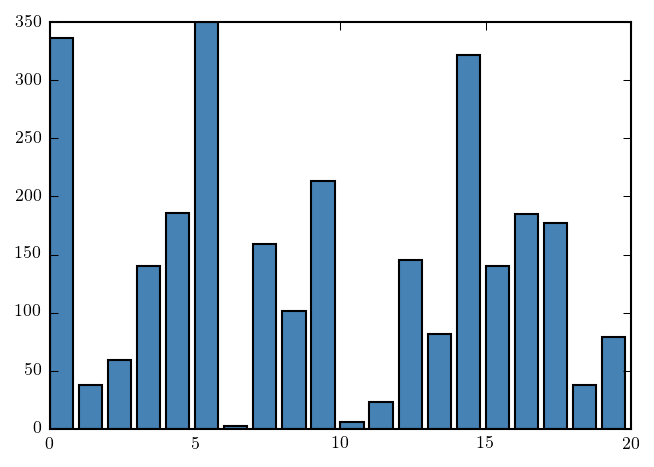

In [47]:
# Plot the sum of topics.
plt.bar(np.arange(len(np.sum(doc_topic_distr, axis=0))), np.average(doc_topic_distr, axis=0), color='steelblue')

In [10]:
import pyLDAvis
import pandas as pd
import funcy as fp
from pyLDAvis import prepare as vis_prepare

def _extract_data(docs, vect, lda):
    #LDA scikit-learn implementation seems to have buggy code.
    #Topic_term_dists and doc_topic_dists isn't accummulated to 1.
    #Hence norm function implemented to normalize the distributions.
    norm = lambda data: pd.DataFrame(data).div(data.sum(1),axis=0).values
    vected = vect.fit_transform(docs)
    doc_topic_dists = norm(lda.fit_transform(vected))
    
    return lda,vect, dict(
                      doc_lengths = docs.str.len(),
                      vocab = vect.get_feature_names(),
                      term_frequency = vected.sum(axis=0).tolist()[0],
                      topic_term_dists = norm(lda.components_),
                      doc_topic_dists = doc_topic_dists)

def prepare(docs, vect, lda, **kwargs):
    """Create Prepared Data from sklearn's vectorizer and Latent Dirichlet
    Application.

    Parameters
    ----------
    docs : Pandas Series.
        Documents to be passed as an input.
    vect : Scikit-Learn Vectorizer (CountVectorizer,TfIdfVectorizer).
        vectorizer to convert documents into matrix sparser
    lda  : sklearn.decomposition.LatentDirichletAllocation.
        Latent Dirichlet Allocation

    **kwargs: Keyword argument to be passed to pyLDAvis.prepare()


    Returns
    -------
    prepared_data : PreparedData
          the data structures used in the visualization


    Example
    --------
    For example usage please see this notebook:
    http://nbviewer.ipython.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

    See
    ------
    See `pyLDAvis.prepare` for **kwargs.
    """
    
    opts = fp.merge(_extract_data(docs, vect, lda)[2], kwargs)

    return vis_prepare(**opts)

vis_data = prepare(docs, tf_vectorizer, lda)





AttributeError: 'list' object has no attribute 'str'

# NMF

In [60]:
# from sklearn.decomposition import NMF


# n_samples = 100000
# n_features = 10000
# n_topics = 6
# n_top_words = 20


# # # Use tf-idf features for NMF.
# print("Extracting tf-idf features for NMF...")
# tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=n_features)


# t0 = time()
# tfidf = tfidf_vectorizer.fit_transform(review_flatten[:n_samples])
# print("done in %0.3fs." % (time() - t0))


# # Fit the NMF model
# print("Fitting the NMF model with tf-idf features,"
#       "n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in NMF model:")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

In [ ]:
import pandas as pd
import pickle
import numpy as np
from itertools import chain
from collections import OrderedDict


# Load the bar review dataset 
review = pd.read_pickle('../output/bar_reviews_cleaned_and_tokenized.pickle')
